In [1]:
#importando librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import os
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.lines as mlines

In [2]:
# Cargar el conjunto de datos 
df_2025_directivo = pd.read_excel('raw/datos_2025_final.xlsx', sheet_name="Directivos")
df_2025_miembro = pd.read_excel('raw/datos_2025_final.xlsx', sheet_name="Miembros")
df_2023 = pd.read_excel('raw/datos_2023.xlsx')


In [3]:
# Formar 3 datasets: Total, directivos y miembros


# Cálculo del promedio por dimensión agrupando por persona-componente
# Cálculo del promedio por componente organizando por componente
df_2025_directivo['Categoria'] = "Directivo"
df_2025_miembro['Categoria'] = "Miembro"

df_2025 = pd.concat([df_2025_directivo, df_2025_miembro], axis=0, ignore_index=True)


In [4]:
# Excluir a las personas que no tienen mayúsculas en todas sus letras
df_2025 = df_2025[df_2025['Persona'].str.isupper()]

# Prueba
len(df_2025)
# 2638

3896

In [5]:
# cambiar los nombres de la Dimension
reemplazos = {
    "1. Dimensión de la Estrategía y Dirección": "1. Estrategia",
    "2. Dimensión Humana": "2. Humana",
    "3. Dimensión de los Procesos de Gestión del Conocimiento": "3. Procesos",
    "4. Dimensión de la Tecnología": "4. Tecnología",
    "5. Dimensión de Indicadores": "5. Indicadores"
}

df_2025["Dimension"] = df_2025["Dimension"].replace(reemplazos)

df_2023["Dimension"] = df_2023["Dimension"].replace(reemplazos)



In [6]:
df_likert = df_2025[(df_2025['TipoPregunta'] == 'Likert') | (df_2025['TipoPregunta'] == 'Texto')]
print(len(df_likert))

3620


In [7]:
df_likert = df_likert[~((df_likert['TipoPregunta'] == "Texto") & ((df_likert['Valor'] == 3) | (df_likert['Valor'].isna())))]
print(len(df_likert))

3553


In [8]:
# Seleccionar preguntas Likert

# Prueba
len(df_likert)
# 1723

df_likert['Valor'] = pd.to_numeric(df_likert['Valor'], errors='coerce')

In [9]:
print(len(df_likert))

3553


# Promedio por Dimensión

In [10]:
#función promedio por dimension o componente
def promedio_dimension(DataSet, grupo = ['Dimension']):
    
    # 1. Promedia el resultados por persona componeten y dimension
    promedio_dimension_componente_persona = DataSet.groupby(['Dimension','Subdimension', 'Persona'])['Valor'].mean().reset_index()
    
    # 2. Promedia esos resultados por dimension y componetn
    promedio_dimension = promedio_dimension_componente_persona.groupby(grupo)['Valor'].mean().reset_index()
  
    return promedio_dimension

In [11]:
# Generar tabla de promedios totales por dimensión
df_promedio_dim = promedio_dimension(df_likert)

df_promedio_dim['Valor'] = df_promedio_dim['Valor'].astype(float).round(1)

# cambiar los nombres de la Dimension
reemplazos = {
    "1. Dimensión de la Estrategía y Dirección": "Estrategia",
    "2. Dimensión Humana": "Humana",
    "3. Dimensión de los Procesos de Gestión del Conocimiento": "Procesos",
    "4. Dimensión de la Tecnología": "Tecnología",
    "5. Dimensión de Indicadores": "Indicadores"
}

df_promedio_dim["Dimension"] = df_promedio_dim["Dimension"].replace(reemplazos)


In [12]:
# Generar tablas de promedios por dimension por directivo
df_promedio_dim_dir = promedio_dimension(df_likert[df_likert['Categoria'] == "Directivo"])
df_promedio_dim_dir['Categoria'] = "Directivo"

#  Generar tablas de promedios por dimension por miembro
df_promedio_dim_mie = promedio_dimension(df_likert[df_likert['Categoria'] == "Miembro"])
df_promedio_dim_mie['Categoria'] = "Miembro"

#concatenar tablas
df_promedio_dim_cat = pd.concat([df_promedio_dim_dir, df_promedio_dim_mie], axis=0, ignore_index=True)

# Pasar a un decimal
df_promedio_dim_cat['Valor'] = df_promedio_dim_cat['Valor'].astype(float).round(1)


In [13]:
# graficar radar chart de dimensión directivos vs miembros
def generar_grafico_radar(df, nombre_archivo, theta, color = None):
    fig = px.line_polar(df, 
                        r = "Valor",
                        theta = theta,
                        line_close = True,
                        color = color,
                        text= "Valor",
                        template= "none"
                        )

    # Personalizar el eje radial
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[1, 5],
                dtick=1  # separación entre líneas
            )
        )
    )

    fig.update_layout(
            legend_title_text=''
    )

    fig.update_traces(fill='toself',            # Opcional: rellena el área
        textposition='top left')  # opcional, para rellenar el área

    ruta_salida = "plots3/"
    ruta_completa = os.path.join(ruta_salida, f"{nombre_archivo}.png")
    fig.write_image(ruta_completa, width=800, height=600)

In [14]:
generar_grafico_radar(df_promedio_dim, nombre_archivo="promedio_total_dimension", theta = "Dimension")

In [15]:
generar_grafico_radar(df_promedio_dim_cat, nombre_archivo="promedio_cat_dimension", theta = "Dimension", color = 'Categoria')

## Promedio por componente

In [16]:
# Generar las tablas total y vs
df_comp_total = promedio_dimension(df_likert, grupo = ['Dimension','Subdimension'])

# Generar las tablas vs
df_comp_dir = promedio_dimension(df_likert[df_likert['Categoria'] == "Directivo"], grupo = ['Dimension','Subdimension'])
df_comp_miem = promedio_dimension(df_likert[df_likert['Categoria'] == "Miembro"], grupo = ['Dimension','Subdimension'])

# Concatenar tablas
df_comp_dir['Categoria'] = "Directivo"
df_comp_miem['Categoria'] = "Miembro"
df_comp_vs = pd.concat([df_comp_dir, df_comp_miem])


In [17]:
# Agregar las filas faltante de componentes y agregar el valor 1
df_comp_total.loc[len(df_comp_total)] = ["1. Estrategia", "1.1 Responsable", 1]
# Agregar las filas faltante de componentes y agregar el valor 1
df_comp_total.loc[len(df_comp_total)] = ["1. Estrategia", "1.4 Presupuesto", 1]
# Agregar las filas faltante de componentes y agregar el valor 1
df_comp_total.loc[len(df_comp_total)] = ["2. Humana", "2.4 Redes de conocimiento", 1]


In [18]:
# Agregar las filas faltante de componentes y agregar el valor 1
df_comp_vs.loc[len(df_comp_vs)] = ["1. Estrategia", "1.1 Responsable", 1, "Directivo"]

df_comp_vs.loc[len(df_comp_vs)] = ["1. Estrategia", "1.1 Responsable", 1, "Miembro"]

df_comp_vs.loc[len(df_comp_vs)] = ["1. Estrategia", "1.4 Presupuesto", 1, "Directivo"]

df_comp_vs.loc[len(df_comp_vs)] = ["1. Estrategia", "1.4 Presupuesto", 1, "Miembro"]

df_comp_vs.loc[len(df_comp_vs)] = ["2. Humana", "2.4 Redes de conocimiento", 1, "Directivo"]

df_comp_vs.loc[len(df_comp_vs)] = ["2. Humana", "2.4 Redes de conocimiento", 1, "Miembro"]


In [19]:
# Convertir a valor numérico y redondear a un decimal
df_comp_total['Valor'] = df_comp_total['Valor'].astype(float).round(1)

# Ordenar 
df_comp_total = df_comp_total.sort_values(by=["Dimension", "Subdimension"])

# Convertir a valor numérico y redondear a un decimal
df_comp_vs['Valor'] = df_comp_vs['Valor'].astype(float).round(1)

# Ordenar 
df_comp_vs = df_comp_vs.sort_values(by=["Dimension", "Subdimension"])

In [20]:
# Reemplazar el nombre del componente 2 de la dimensión 1
reemplazos_comp = {
    "1.3 Definición del Gestión del Conocimiento en la organización ":"1.3 Definición de GC",
    "2.5 Motivación e incentivos": "2.5 Motivación",
    "3.1 Matriz de conocimiento estratégico": "3.1 Matriz",
    "3.3 Procesos de gestión del conocimiento": "3.3 Procesos de GC",
    "5.2 Indicadores de generación de valor": "5.2 Ind. de valor"
}

# Reemplazar en la tabla de totales
df_comp_total["Subdimension"] = df_comp_total["Subdimension"].replace(reemplazos_comp)

# Reemplazar en la tabla de vs
df_comp_vs["Subdimension"] = df_comp_vs["Subdimension"].replace(reemplazos_comp)

### Dimensión Estrategia

In [21]:
generar_grafico_radar(df_comp_vs[df_comp_vs['Dimension'] == "1. Estrategia"],
                      nombre_archivo="prom_estrategia_vs",
                      theta="Subdimension",
                      color="Categoria")

In [22]:
generar_grafico_radar(df_comp_total[df_comp_total['Dimension'] == "1. Estrategia"], 
                      nombre_archivo = 'prom_estrategia_total', 
                      theta="Subdimension")

### Dimensión Humana

In [23]:
generar_grafico_radar(df_comp_vs[df_comp_vs['Dimension'] == "2. Humana"],
                      nombre_archivo="prom_humana_vs",
                      theta="Subdimension",
                      color="Categoria")

In [24]:
generar_grafico_radar(df_comp_total[df_comp_total['Dimension'] == "2. Humana"], 
                      nombre_archivo = 'prom_humana_total', 
                      theta="Subdimension")

### Dimensión Procesos

In [25]:
generar_grafico_radar(df_comp_vs[df_comp_vs['Dimension'] == "3. Procesos"],
                      nombre_archivo="prom_procesos_vs",
                      theta="Subdimension",
                      color="Categoria")

In [26]:
generar_grafico_radar(df_comp_total[df_comp_total['Dimension'] == "3. Procesos"], 
                      nombre_archivo = 'prom_procesos_total', 
                      theta="Subdimension")

### Dimensión Tecnología

In [27]:
# Cocnatenar tablas de total y vs
df_comp_total['Categoria'] = "Total"
df_comp_concat = pd.concat([df_comp_vs, df_comp_total], axis = 0, ignore_index=True)

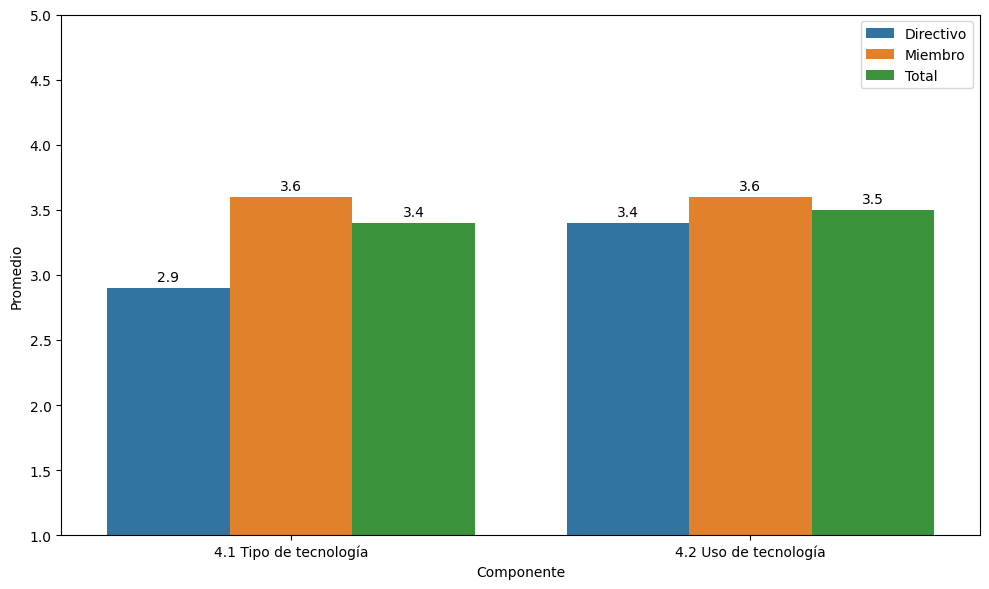

In [28]:
# Generar gráfico de barras
# Crear el gráfico
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_comp_concat[df_comp_concat['Dimension'] == "4. Tecnología"], x='Subdimension', y='Valor', hue='Categoria')

# Agregar los valores arriba de las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# Personalizar el gráfico
plt.xlabel('Componente')
plt.ylabel('Promedio')
plt.legend(title='')
plt.ylim(1, 5)
plt.tight_layout()
plt.savefig("plots3/prom_tecnologia.png", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
generar_grafico_radar(df_comp_concat[(df_comp_concat['Dimension'] == "4. Tecnología") & (df_comp_concat['Categoria']=='Total')], nombre_archivo="promedio_tecnologia_radar", theta="Subdimension")

### Dimensión Indicadores

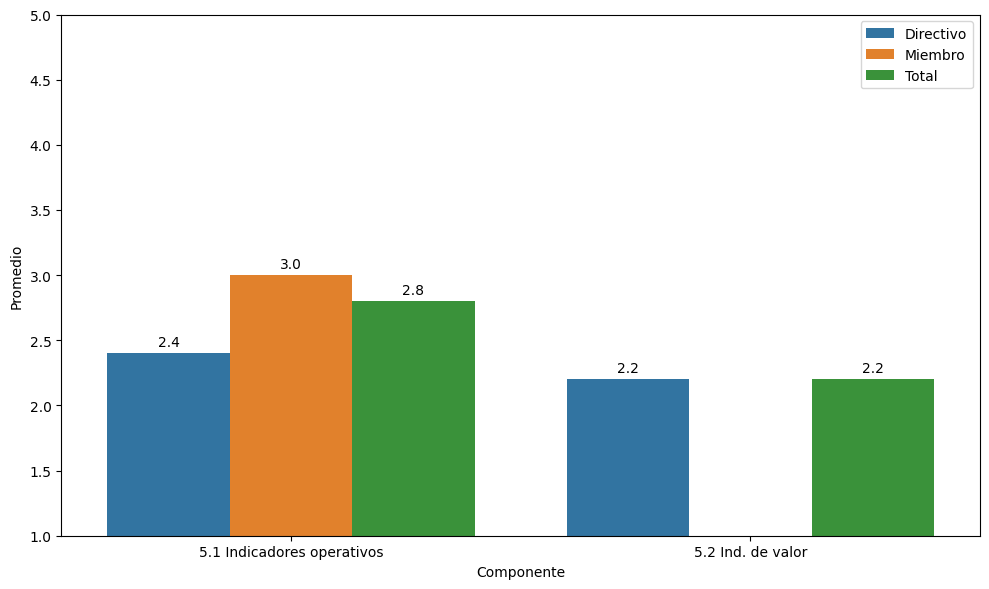

In [30]:
# Generar gráfico de barras
# Crear el gráfico
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_comp_concat[df_comp_concat['Dimension'] == "5. Indicadores"], x='Subdimension', y='Valor', hue='Categoria')

# Agregar los valores arriba de las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# Personalizar el gráfico
plt.xlabel('Componente')
plt.ylabel('Promedio')
plt.legend(title='')
plt.ylim(1, 5)
plt.tight_layout()
plt.savefig("plots3/prom_indicadores.png", dpi=300, bbox_inches='tight')
plt.show()

In [31]:
generar_grafico_radar(df_comp_concat[(df_comp_concat['Dimension'] == "5. Indicadores") & (df_comp_concat['Categoria']=='Total')], nombre_archivo="promedio_indicadores_radar", theta="Subdimension")

## Análisis de motivación y satisfacción

### Directivos

#### Grafico 7.1

In [32]:
# Seleccionar la pregunta 
df_7_1 = df_likert[df_likert['Pregunta'] == '¿Cuán de acuerdo está usted con esta afirmación: "Existe motivación y entusiasmo por implementar la gestión del conocimiento en la empresa "? ']

df_7_1['Valor'] = df_7_1['Valor'].astype(int)

C:\Users\User\AppData\Local\Temp\ipykernel_20484\3737751306.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
# definir función para elaborar el gráfico

def preguntas_likert(df, nombre_archivo):
    # Contar la cantidad de respuestas por valor (1 al 5)
    conteo = df['Valor'].value_counts().sort_index()

    # Asegurarte de que se incluyan todos los valores del 1 al 5, aunque alguno no esté presente
    conteo = conteo.reindex(range(1, 6), fill_value=0)

    # Crear gráfico de barras con seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(data=df, x='Valor', palette="Blues", order=[1, 2, 3, 4, 5])
    plt.xlabel('')
    plt.ylabel('Frecuencia')
    plt.title('')
    plt.grid(axis='y', linestyle='', alpha=0.7)

    # Agregar los valores encima de las barras
    for p in ax.patches:
        height = p.get_height()  # Obtener la altura de la barra
        ax.text(p.get_x() + p.get_width() / 2, height + 0.1, str(int(height)),  # Posicionar el texto
                ha="center", va="bottom", fontsize=8)  # Ajusta el tamaño de la fuente aquí

    # Guardar el gráfico
    plt.tight_layout()
    ruta_salida = "plots3/"
    ruta_completa = os.path.join(ruta_salida, f"{nombre_archivo}.png")
    plt.savefig(ruta_completa, format='png', bbox_inches='tight')
    plt.close()

In [34]:
preguntas_likert(df_7_1, "grafico_7_1")

C:\Users\User\AppData\Local\Temp\ipykernel_20484\4092244653.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




In [35]:
def preguntas_likert_porcentaje(df, nombre_archivo, opciones):
    """
    df: DataFrame que contiene la columna 'Valor' con respuestas del 1 al 5
    nombre_archivo: nombre del archivo de salida (sin extensión)
    opciones: diccionario que mapea cada número a su descripción, por ejemplo {1: "Muy en desacuerdo", 2: "En desacuerdo", ...}
    """
    # Contar la cantidad de respuestas por valor (1 al 5)
    conteo = df['Valor'].value_counts().sort_index()
    conteo = conteo.reindex(range(1, 6), fill_value=0)

    total_respuestas = conteo.sum()
    porcentaje = (conteo / total_respuestas) * 100

    # Crear un nuevo DataFrame para graficar
    datos = pd.DataFrame({
        'Valor': range(1, 6),
        'Porcentaje': porcentaje.values
    })

    # Asignar colores personalizados según las opciones
    colores = [sns.color_palette("Blues", n_colors=5)[i] for i in range(5)]  # Colores graduales de azul

    # Crear gráfico de barras con seaborn, usando los colores personalizados
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=datos, x='Valor', y='Porcentaje', palette=colores, order=[1, 2, 3, 4, 5])
    plt.xlabel('')
    plt.ylabel('Porcentaje (%)')
    plt.title('')
    plt.ylim(0, max(porcentaje) + 10)  

    # Agregar los porcentajes encima de las barras
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 1, f'{height:.1f}%', 
                ha="center", va="bottom", fontsize=8)

    # Crear la leyenda personalizada
    handles = [mlines.Line2D([], [], color=colores[i], marker='s', linestyle='', markersize=10, 
                             label=f"{key}: {value}") for i, (key, value) in enumerate(opciones.items())]
    ax.legend(handles=handles, title="Opciones", bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol = 3)

    # Guardar el gráfico
    plt.tight_layout()
    ruta_salida = "plots3/"
    os.makedirs(ruta_salida, exist_ok=True)
    ruta_completa = os.path.join(ruta_salida, f"{nombre_archivo}.png")
    plt.savefig(ruta_completa, format='png', bbox_inches='tight')
    plt.close()


In [36]:
opciones_7_1 = {
    "1": "Muy en desacuerdo",
    "2": "En desacuerdo",
    "3": "Neutral",
    "4": "De acuerdo",
    "5": "Muy de acuerdo",
}

In [37]:
preguntas_likert_porcentaje(df_7_1, opciones=opciones_7_1, nombre_archivo="grafico_7_1_porcentaje")

C:\Users\User\AppData\Local\Temp\ipykernel_20484\1721997734.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




#### Grafico 7.2

In [38]:
# filtrar la pregunta 7.2
df_7_2 = df_2025[df_2025['Pregunta'] == '¿Cuáles de los siguientes obstáculos ha observado en la implementación de la gestión del conocimiento? (Seleccione todas las que apliquen)']
df_7_2['Valor'] =df_7_2['Valor'].astype('str')

C:\Users\User\AppData\Local\Temp\ipykernel_20484\2274238124.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
opciones_7_2 = {
    "1": "Falta de presupuesto",
    "2": "Resistencia al cambio",
    "3": "Falta de formación",
    "4": "Ineficientes herramientas digitales",
    "5": "Falta de motivación",
}


In [40]:
# Función generadora de gráficos de barra para preguntas de opción múltiple

def preguntas_multiple(df, opciones, nombre_archivo):

    # Paso 1: Separar los valores por coma
    valores = df["Valor"].str.split(",")

    # Paso 2: Unir todos los valores en una lista
    valores_flat = [v for sublist in valores for v in sublist]

    # Paso 3: Filtrar eliminando "Otros"
    valores_filtrados = [v for v in valores_flat if v in opciones]

    # Paso 4: Contar frecuencia por número
    serie = pd.Series(valores_filtrados)
    frecuencia = serie.value_counts().sort_index()  # index = números como strings

    # Paso 5: Graficar con números en eje x y leyenda con nombres
    fig, ax = plt.subplots()

    # Usar una paleta de colores azules que varíe de celeste a azul oscuro
    colors = sns.color_palette("Blues", len(frecuencia))

    bars = ax.bar(frecuencia.index, frecuencia.values, color = colors)

    # Crear leyenda
    etiquetas = [f"{clave}: {opciones[clave]}" for clave in frecuencia.index]
    ax.legend(bars, etiquetas, title="Opciones", bbox_to_anchor=(0.5, -0.3), loc="center", ncol=2)


    # Etiquetas del gráfico
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")

    # Ajustar el eje Y para que los números sean enteros de dos en dos
    ax.set_yticks(range(0, max(frecuencia.values) + 2, 5)) 

    # Agregar el valor encima de las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, str(int(height)), 
                ha="center", va="bottom", fontsize=8)
        
    plt.tight_layout()

    ruta_salida = "plots3/"
    ruta_completa = os.path.join(ruta_salida, f"{nombre_archivo}.png")
    plt.savefig(ruta_completa, format='png', bbox_inches='tight')
    plt.close()


In [41]:
preguntas_multiple(df_7_2, opciones=opciones_7_2, nombre_archivo="grafico_7_2")

In [42]:
def preguntas_multiple_porcentaje(df, opciones, nombre_archivo):
    # Paso 1: Separar los valores por coma
    valores = df["Valor"].str.split(",")
    
    # Paso 2: Unir todos los valores en una lista
    valores_flat = [v for sublist in valores for v in sublist]
    
    # Paso 3: Filtrar eliminando "Otros"
    valores_filtrados = [v for v in valores_flat if v in opciones]
    
    # Paso 4: Contar frecuencia por número
    serie = pd.Series(valores_filtrados)
    frecuencia = serie.value_counts().sort_index()  # index = números como strings
    
    # Paso 5: Calcular el total de respuestas (número de filas no NAs)
    total_respuestas = df["Valor"].notna().sum()  # Contar filas no NA
    
    # Paso 6: Calcular los porcentajes
    porcentaje = (frecuencia / total_respuestas) * 100
    
    # Paso 7: Graficar con porcentajes en lugar de frecuencias
    fig, ax = plt.subplots()
    
    # Usar una paleta de colores azules que varíe de celeste a azul oscuro
    colors = sns.color_palette("Blues", len(porcentaje))
    
    bars = ax.bar(porcentaje.index, porcentaje.values, color=colors)
    
    # Crear leyenda
    etiquetas = [f"{clave}: {opciones[clave]}" for clave in porcentaje.index]
    ax.legend(bars, etiquetas, title="Opciones", bbox_to_anchor=(0.5, -0.3), loc="center", ncol=2)
    
    # Etiquetas del gráfico
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("Porcentaje")
    
    # Ajustar el eje Y para que los números sean enteros de cinco en cinco
    ax.set_yticks(range(0, 101, 20)) 
    
    # Agregar el valor encima de las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f"{height:.1f}%", 
                ha="center", va="bottom", fontsize=8)
    
    plt.tight_layout()

    ruta_salida = "plots3/"
    ruta_completa = os.path.join(ruta_salida, f"{nombre_archivo}.png")
    plt.savefig(ruta_completa, format='png', bbox_inches='tight')
    plt.close()


In [43]:
preguntas_multiple_porcentaje(df_7_2, opciones=opciones_7_2, nombre_archivo="grafico_7_2_porcentaje")

#### Gráfico 7.3

In [44]:
df_7_3 = df_2025[(df_2025['Pregunta'] == '¿Cuáles consideras son los mayores obstáculos para compartir conocimiento? ') &
                 (df_2025['Categoria'] == "Directivo")]
df_7_3['Valor'] =df_7_3['Valor'].astype('str')

C:\Users\User\AppData\Local\Temp\ipykernel_20484\1773575870.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
opciones_7_3 = {
    "1":"Falta de confianza entre los miembros",
    "2":"El tiempo escaso",
    "3":"Escasa practicidad de las plataformas digitales",
    "4":"Los bajos incentivos",
    "5":"La actitud de las personas"
}

In [46]:
preguntas_multiple(df_7_3, opciones=opciones_7_3, nombre_archivo="grafico_7_3")

In [47]:
preguntas_multiple_porcentaje(df_7_3, opciones=opciones_7_3, nombre_archivo="grafico_7_3_porcentaje")

#### Gráfico 7.4

In [48]:
df_7_4 = df_2025[(df_2025['Pregunta'] == '¿Cuáles de las siguientes áreas cree que necesitan más atención para la estrategia de la gestión del conocimiento? (Seleccione todas las que apliquen)') &
                 (df_2025['Categoria'] == "Directivo")]
df_7_4['Valor'] =df_7_4['Valor'].astype('str')

C:\Users\User\AppData\Local\Temp\ipykernel_20484\1118491517.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
opciones_7_4 = {
    "1":"Formación y capacitación",
    "2":"Cultura organizacional",
    "3":"Liderazgo",
    "4":"Procesos",
    "5":"Motivación"
}

In [50]:
preguntas_multiple(df_7_4, opciones=opciones_7_4, nombre_archivo="grafico_7_4")

In [51]:
preguntas_multiple_porcentaje(df_7_4, opciones_7_4, nombre_archivo="grafico_7_4_porcentaje")

### Miembros

#### Gráfico 8.1

In [52]:
df_8_1= df_2025[(df_2025['Pregunta'] == '¿Cuán de acuerdo está con esta afirmación: "Me siento motivado a participar de la estrategia de gestión del conocimiento?') &
                 (df_2025['Categoria'] == "Miembro")]
df_8_1['Valor'] = df_8_1['Valor'].astype(int)

C:\Users\User\AppData\Local\Temp\ipykernel_20484\3173202493.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
preguntas_likert_porcentaje(df_8_1, opciones=opciones_7_1, nombre_archivo="grafico_8_1_porcentaje")

C:\Users\User\AppData\Local\Temp\ipykernel_20484\1721997734.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




#### Gráfico 8.2

In [54]:
df_8_2= df_2025[(df_2025['Pregunta'] == '¿Cuáles consideras son los mayores obstáculos para compartir conocimiento?') &
                 (df_2025['Categoria'] == "Miembro")]
df_8_2['Valor'] = df_8_2['Valor'].astype('str')

C:\Users\User\AppData\Local\Temp\ipykernel_20484\3320408780.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
opciones_8_2 = {
    "1":"Falta de confianza entre miembros",
    "2":"Tiempo escaso",
    "3":"Escasa practicidad de las plataformas digitales",
    "4":"Bajos incentivos"
}

In [56]:
preguntas_multiple(df_8_2, opciones=opciones_8_2, nombre_archivo="grafico_8_2")

In [57]:
preguntas_multiple_porcentaje(df_8_2, opciones=opciones_8_2, nombre_archivo="graficos_8_2_porcentaje")

#### Grafico 8.3

In [120]:
df_8_3 = df_2025[(df_2025['Pregunta'] == '¿Cuán satisfecho está con el trabajo que viene realizando el líder y los coordinadores de su comunidad?') &
                 (df_2025['Categoria'] == "Miembro") & (df_2025['Nivel estructural'] != "Líder de Comunidad")]
df_8_3 = df_8_3.dropna(subset=['Valor'])
df_8_3['Valor'] = df_8_3['Valor'].astype(float)

In [59]:
preguntas_likert(df_8_3, nombre_archivo="grafico_8_3")

C:\Users\User\AppData\Local\Temp\ipykernel_20484\4092244653.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




In [121]:
opciones_8_3 = {
    "1":"Muy insatisfecho",
    "2":"Insatifecho",
    "3":"Neutral",
    "4":"Satisfecho",
    "5":"Muy satisfecho"
}

In [123]:
preguntas_likert_porcentaje(df_8_3, nombre_archivo="grafico_8_3_likert", opciones=opciones_8_3)

C:\Users\User\AppData\Local\Temp\ipykernel_20484\1721997734.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




preguntas_likert_porcentaje(df_8_3, opciones=opciones_8_3, nombre_archivo="grafico_8_3_porcentaje")

#### Gráfico 8.4

In [124]:
df_8_4 = df_2025[(df_2025['Pregunta'] == '¿Qué tanto te ha beneficiado pertenecer a una comunidad de conocimiento?') &
                 (df_2025['Categoria'] == "Miembro")]
df_8_4['Valor'] = df_8_4['Valor'].astype(float)

C:\Users\User\AppData\Local\Temp\ipykernel_20484\941679590.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [125]:
preguntas_likert(df_8_4, "grafico_8_4")

C:\Users\User\AppData\Local\Temp\ipykernel_20484\4092244653.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




In [128]:
opciones_8_4 = {
    "1":"Muy bajo",
    "2":"Bajo",
    "3":"Neutral",
    "4":"Alto",
    "5":"Muy alto"
}

In [129]:
preguntas_likert_porcentaje(df_8_4, "grafico_8_4_porcentaje", opciones = opciones_8_4)

C:\Users\User\AppData\Local\Temp\ipykernel_20484\1721997734.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




# Análisis de efectividad de herramientas

## Gráfico 9.1

In [63]:
# Función para preguntas likert en un grid
def preguntas_likert_grid(df, ax, titulo):
    # Contar la cantidad de respuestas por valor (1 al 5)
    conteo = df['Valor'].value_counts().sort_index()
    conteo = conteo.reindex(range(1, 6), fill_value=0)

    # Crear gráfico de barras directamente sobre el eje recibido
    sns.countplot(data=df, x='Valor', palette="Blues", order=[1, 2, 3, 4, 5], ax=ax)

    ax.set_xlabel('')
    ax.set_ylabel('Frecuencia')
    ax.set_title(titulo, fontsize = 8)

    # Agregar los valores encima de las barras
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 0.1, str(int(height)),
                ha="center", va="bottom", fontsize=7)

In [64]:
# Generar las tablas 
df_9_1_1 = df_2025[(df_2025['Pregunta'] == '¿Cuán efectivas considera que es la herramienta Viva Engage para la gestión del conocimiento en la organización?')]
df_9_1_1['Valor'] = df_9_1_1['Valor'].astype(float)

df_9_1_2 = df_2025[(df_2025['Pregunta'] == '¿Cuán efectivas considera que es la herramienta Sharepoint para la gestión del conocimiento en la organización?')]
df_9_1_2['Valor'] = df_9_1_2['Valor'].astype(float)

df_9_1_3 = df_2025[(df_2025['Pregunta'] == '¿Cuán efectivas considera que es la herramienta Outlook para la gestión del conocimiento en la organización?')]
df_9_1_3['Valor'] = df_9_1_3['Valor'].astype(float)

C:\Users\User\AppData\Local\Temp\ipykernel_20484\631689699.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_20484\631689699.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_20484\631689699.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

C:\Users\User\AppData\Local\Temp\ipykernel_20484\3754240498.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\User\AppData\Local\Temp\ipykernel_20484\3754240498.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\User\AppData\Local\Temp\ipykernel_20484\3754240498.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




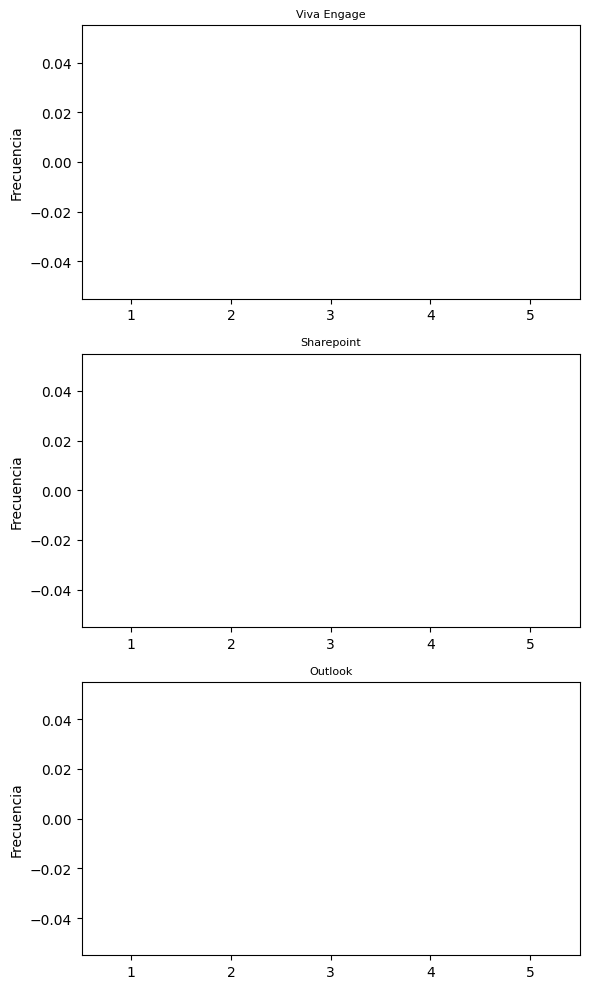

In [65]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 10))

preguntas_likert_grid(df_9_1_1, axes[0], "Viva Engage")
preguntas_likert_grid(df_9_1_2, axes[1], "Sharepoint")
preguntas_likert_grid(df_9_1_3, axes[2], "Outlook")

plt.tight_layout()

ruta_salida = "plots3/"
ruta_completa = os.path.join(ruta_salida, f"{"gráfico_9_1"}.png")
plt.savefig(ruta_completa, format='png', bbox_inches='tight')

plt.show()

def obtener_conteo(df):
    conteo = df['Valor'].value_counts().sort_index()
    return conteo.reindex([str(i) for i in range(1, 6)], fill_value=0)

def graficar_likert_suavizado(df1, df2, df3, etiquetas, nombre_archivo):
    # Obtener conteos
    conteo1 = obtener_conteo(df1)
    conteo2 = obtener_conteo(df2)
    conteo3 = obtener_conteo(df3)

    x = list(range(1, 6))

    plt.figure(figsize=(8, 5))

    sns.lineplot(x=x, y=conteo1.values, marker='o', label=etiquetas[0], linewidth=2)
    sns.lineplot(x=x, y=conteo2.values, marker='o', label=etiquetas[1], linewidth=2)
    sns.lineplot(x=x, y=conteo3.values, marker='o', label=etiquetas[2], linewidth=2)

    plt.xticks(x)
    plt.ylabel('Frecuencia')
    plt.xlabel('Valor Likert')
    plt.title('Comparación de efectividad', fontsize=10)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    ruta_salida = "plots3/"
    ruta_completa = os.path.join(ruta_salida, f"{nombre_archivo}.png")
    plt.savefig(ruta_completa, format='png', bbox_inches='tight')

    plt.show()

graficar_likert_suavizado(df_9_1_1, df_9_1_2, df_9_1_3, etiquetas = ["Viva Engage", "Sharepoint", "Outlook"], nombre_archivo="grafico_9_1")

## Gráfico 9.2

def obtener_conteo(df):
    conteo = df['Valor'].value_counts().sort_index()
    return conteo.reindex([str(i) for i in range(1, 6)], fill_value=0)

def graficar_likert_suavizado(*dfs, etiquetas, nombre_archivo):
    # Verificar que el número de etiquetas coincida con el número de dataframes
    if len(dfs) != len(etiquetas):
        raise ValueError("El número de dataframes debe coincidir con el número de etiquetas")

    # Obtener los conteos para cada dataframe
    conteos = [obtener_conteo(df) for df in dfs]

    x = list(range(1, 6))

    plt.figure(figsize=(8, 5))

    # Graficar cada dataframe
    for i, conteo in enumerate(conteos):
        sns.lineplot(x=x, y=conteo.values, marker='o', label=etiquetas[i], linewidth=2)

    plt.xticks(x)
    plt.ylabel('Frecuencia')
    plt.xlabel('Valor Likert')
    plt.title('Comparación de efectividad', fontsize=10)
    plt.legend()
    plt.tight_layout()
    ruta_salida = "plots3/"
    ruta_completa = os.path.join(ruta_salida, f"{nombre_archivo}.png")
    plt.savefig(ruta_completa, format='png', bbox_inches='tight')
    plt.show()

In [66]:
df_9_2_1 = df_2025[df_2025['Pregunta'] == "¿Qué tan efectivas consideras las herramientas para la identificación  del conocimiento (Matriz/Directorio)?"]
df_9_2_1['Valor'] = df_9_2_1['Valor'].astype(float)

df_9_2_2 = df_2025[df_2025['Pregunta'] == "¿Qué tan efectivas consideras las herramientas para la captura del conocimiento (Lecciones aprendidas/Oportunidades de Mejora/Innovación)?"]
df_9_2_2['Valor'] = df_9_2_2['Valor'].astype(float)

df_9_2_3 = df_2025[df_2025['Pregunta'] == "¿Qué tan efectivas consideras las herramientas para el almacenamiento del conocimiento (Biblioteca)?"]
df_9_2_3['Valor'] = df_9_2_3['Valor'].astype(float)

df_9_2_4 = df_2025[df_2025['Pregunta'] == "¿Qué tan efectivas consideras las herramientas para la distribución del conocimiento (Agenda)?"]
df_9_2_4['Valor'] = df_9_2_4['Valor'].astype(float)

df_9_2_5 = df_2025[df_2025['Pregunta'] == "¿Qué tan efectivas consideras las herramientas para la aplicación del conocimiento (Foros)?"]
df_9_2_5['Valor'] = df_9_2_5['Valor'].astype(float)

C:\Users\User\AppData\Local\Temp\ipykernel_20484\4251170939.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_20484\4251170939.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_20484\4251170939.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

graficar_likert_suavizado(df_9_2_1, df_9_2_2, df_9_2_3, df_9_2_4, df_9_2_5, etiquetas=["Matriz/Directorio",
                                                                                       "LA, OPPM, Innov",
                                                                                       "Biblioteca",
                                                                                       "Agenda",
                                                                                       "Foros"], nombre_archivo="grafico_9_2")

# Data 2023

In [67]:
df_2023 = df_2023[df_2023['Respuesta'] != 0]

In [68]:
df_2023 = df_2023.rename(columns={'Respuesta': 'Valor'})


In [69]:
df_promedio_dim_2023 = promedio_dimension(df_2023)

In [70]:
df_promedio_dim['year'] = "2025"
df_promedio_dim_2023['year'] = "2023"

In [71]:
df_promedio_dim_total = pd.concat([df_promedio_dim, df_promedio_dim_2023], ignore_index=True)


In [72]:
# Pasar a un decimal
df_promedio_dim_total['Valor'] = df_promedio_dim_total['Valor'].astype(float).round(1)

In [73]:
generar_grafico_radar(df_promedio_dim_total, theta="Dimension", nombre_archivo="radar_promedio_total_comparado", color = 'year')

In [74]:
df_2023_entrevistas = pd.read_excel("raw/datos_2023_entrevistas.xlsx")

In [75]:
df_2023_entrevistas['year'] = "2023"

In [76]:
df_promedio_dim_total_2 = pd.concat([df_promedio_dim, df_2023_entrevistas], ignore_index=True)

In [77]:
generar_grafico_radar(df_promedio_dim_total_2, nombre_archivo="radar_promedio_dimension_entrevistas", color = 'year', theta = 'Dimension')

## Gráficos por categoría 25 vs 23

In [78]:
# unir la columna categoria
df_temp = pd.read_excel('raw/datos_2025_categoria.xlsx')

In [79]:
df_temp.head()

,#,Nombre Colaborador,Unnamed: 2,E-mail Corporativo,Categoria 2025,Categoria 2023,Estado
0,1,"ABREGU GONZALES, JOSEP JESUS",NaN,jabregu@arpl.com,Ing Junior,No participó,NaN
1,2,"ACUÑA URBINA, DARIO ENRIQUE","ACUÑA URBINA, DARIO ENRIQUE",dacuna@arpl.com,Gestor de Proyecto,Gestor de Proyecto,OK
2,3,"ALATA CHUMPITAZ, GUILLERMO SEGUNDO",NaN,galata@arpl.com,Gestor de Proyecto,Gestor de Proyecto,OK
3,4,"ALCA MENDOZA, EDGARD CECILIO",NaN,ealca@arpl.com,Jefe de Proyecto,Jefe de Proyecto,OK
4,5,"ALVARADO GUILLEN, VIRGILIO CAMILO",NaN,Alvarado@arpl.com,Jefe de Proyecto,Diseñador,CAMBIA


In [80]:
df_likert = df_likert.merge(
    df_temp[['E-mail Corporativo', 'Categoria 2025']],
    how='left',
    left_on='Email',
    right_on='E-mail Corporativo'
)

df_likert = df_likert.drop(columns=['E-mail Corporativo'])


In [81]:
# limpiar la columna categoría del 2023
df_2023['Area'] = df_2023['Area'].str[3:]

In [82]:
df_2023['Area']= df_2023['Area'].replace('Gestor Proyecto', 'Gestor de Proyecto')


In [83]:
df_likert['Categoria 2025'].head()

0    Jefe de Proyecto
1    Jefe de Proyecto
2    Jefe de Proyecto
3    Jefe de Proyecto
4    Jefe de Proyecto
Name: Categoria 2025, dtype: object

In [84]:
def generar_grafico_radar_categoria(categoria):

    promedio_dimension_gerente_25 = df_likert[df_likert['Categoria 2025'] == categoria].groupby(['Dimension'])['Valor'].mean().reset_index()
    promedio_dimension_gerente_25['year'] = '2025'
    promedio_dimension_gerente_23 = df_2023[df_2023['Area'] == categoria].groupby(['Dimension'])['Valor'].mean().reset_index()
    promedio_dimension_gerente_23['year'] = '2023'
    promedio_dimension_categoria = pd.concat([promedio_dimension_gerente_25, promedio_dimension_gerente_23], ignore_index=True)
    promedio_dimension_categoria['Valor']=promedio_dimension_categoria['Valor'].astype(float).round(1)

    generar_grafico_radar(promedio_dimension_categoria, nombre_archivo=categoria + " radar_dimension", theta="Dimension", color= 'year')

In [85]:
generar_grafico_radar_categoria("Gerente")

In [86]:
lista_categorias = ["Gerente",
                    "Diseñador",
                    "Gestor de Proyecto",
                    "Ing Intermedio",
                    "Ing Junior",
                    "Ing Senior",
                    "Jefe de Proyecto"]

In [87]:
for categ in lista_categorias:
    generar_grafico_radar_categoria(categ)

# Gráficos 2025 por categoría

In [88]:
def promedio_dimension_categoria(DataSet, grupo = ['Dimension']):
    
    # 1. Promedia el resultados por persona componeten y dimension
    promedio_dimension_componente_persona = DataSet.groupby(['Dimension','Subdimension', 'Categoria 2025', 'Persona'])['Valor'].mean().reset_index()
    
    # 2. Promedia esos resultados por dimension y componetn
    promedio_dimension = promedio_dimension_componente_persona.groupby(grupo)['Valor'].mean().reset_index()
  
    return promedio_dimension

In [89]:
df_promedio_categorias_2025 = promedio_dimension_categoria(df_likert, grupo = ['Dimension', 'Categoria 2025'])

In [90]:
df_promedio_categorias_2025['Valor'] = df_promedio_categorias_2025['Valor'].astype(float).round(1)

In [91]:
generar_grafico_radar(df_promedio_categorias_2025, 
                      nombre_archivo="radar_categorias_2025",
                      theta="Dimension",
                      color="Categoria 2025")

In [92]:
def generar_grafico_radar_2(df, nombre_archivo, theta, color=None):
    fig = px.line_polar(
        df, 
        r="Valor",
        theta=theta,
        line_close=True,
        color=color,
        template="none"
    )

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[1, 5],
                dtick=1
            )
        ),
        legend_title_text=''
    )

    ruta_salida = "plots3/"
    ruta_completa = os.path.join(ruta_salida, f"{nombre_archivo}.png")
    fig.write_image(ruta_completa, width=800, height=600)


In [93]:
generar_grafico_radar_2(df_promedio_categorias_2025, 
                      nombre_archivo="radar_categorias_2025",
                      theta="Dimension",
                      color="Categoria 2025")

In [94]:
orden_personalizado = ['Gerente', 'Gestor de Proyecto', 'Jefe de Proyecto', 'Ing Senior', 'Ing Intermedio',
                       'Ing Junior', 'Diseñador']

In [95]:
def generar_grafico_radar_3(df, nombre_archivo, theta, color=None, orden_categorias=None):
    if color and orden_categorias:
        df[color] = pd.Categorical(df[color], categories=orden_categorias, ordered=True)

    fig = px.line_polar(
        df, 
        r="Valor",
        theta=theta,
        line_close=True,
        color=color,
        template="none"
    )

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[1, 5],
                dtick=1
            )
        ),
        legend_title_text=''
    )

    ruta_salida = "plots3/"
    ruta_completa = os.path.join(ruta_salida, f"{nombre_archivo}.png")
    fig.write_image(ruta_completa, width=800, height=600)

In [96]:
generar_grafico_radar_3(df_promedio_categorias_2025, 
                      nombre_archivo="radar_categorias_2025_ordenado",
                      theta="Dimension",
                      color="Categoria 2025",
                      orden_categorias=orden_personalizado)

In [97]:
def porcentaje_4_5(df):
        
    # Filtrar valores no nulos
    valores_validos = df['Valor'].dropna()

    # Contar cuántos marcaron 4 o 5
    conteo_4_5 = valores_validos.isin([4, 5]).sum()

    # Calcular el total de respuestas válidas (no NA)
    total_respuestas = len(valores_validos)

    # Calcular el porcentaje
    porcentaje_4_5 = (conteo_4_5 / total_respuestas) * 100

    print(f"Porcentaje de personas que marcaron 4 o 5: {porcentaje_4_5:.2f}%")


In [98]:
porcentaje_4_5(df_9_1_1)

Porcentaje de personas que marcaron 4 o 5: 48.98%


In [99]:
porcentaje_4_5(df_9_1_2)

Porcentaje de personas que marcaron 4 o 5: 78.00%


In [100]:
porcentaje_4_5(df_9_1_3)

Porcentaje de personas que marcaron 4 o 5: 72.00%


In [101]:
porcentaje_4_5(df_9_2_1)

Porcentaje de personas que marcaron 4 o 5: 48.21%


In [102]:
porcentaje_4_5(df_9_2_2)

Porcentaje de personas que marcaron 4 o 5: 51.79%


In [103]:
porcentaje_4_5(df_9_2_3)

Porcentaje de personas que marcaron 4 o 5: 55.36%


In [104]:
porcentaje_4_5(df_9_2_4)

Porcentaje de personas que marcaron 4 o 5: 53.57%


In [105]:
porcentaje_4_5(df_9_2_5)

Porcentaje de personas que marcaron 4 o 5: 53.57%


# Gráficos por componente 23 vs 25

## Estrategia

In [106]:
# generar promedio por componente 23 y unirlo a 2025
df_comp_23 = promedio_dimension(df_2023, grupo=['Dimension', 'Subdimension'])

In [107]:
df_comp_23['Subdimension'] = df_comp_23['Subdimension'].str.replace('\n', '', regex=False)

In [108]:
reemplazos_comp = {
    "1.1 Definición del Gestión del Conocimiento en la organización":"1.3 Definición de GC",
    "1.3 Responsable":"1.1 Responsable",
    "2.5 Motivación e incentivos": "2.5 Motivación",
    "3.1 Matriz de conocimiento estratégico": "3.1 Matriz",
    "3.3 Procesos de gestión del conocimiento": "3.3 Procesos de GC",
    "5.2 Indicadores de generación de valor": "5.2 Ind. de valor"
}

# Reemplazar en la tabla de totales
df_comp_23["Subdimension"] = df_comp_23["Subdimension"].replace(reemplazos_comp)

In [109]:
df_comp_23['year'] = '2023'

In [110]:
df_comp_total['year'] = '2025'

In [111]:
df_comp_23_25 = pd.concat([df_comp_23, df_comp_total.drop('Categoria', axis=1)], ignore_index=True)

In [112]:
df_comp_23_25.head()

,Dimension,Subdimension,Valor,year
0,1. Estrategia,1.3 Definición de GC,3.279365,2023
1,1. Estrategia,1.2 Plan estratégico,3.488690,2023
2,1. Estrategia,1.1 Responsable,3.261905,2023
3,1. Estrategia,1.4 Presupuesto,3.250000,2023
4,2. Humana,2.1 Liderazgo,3.593074,2023


In [113]:
df_comp_23_25['Valor'] = df_comp_23_25['Valor'].astype(float).round(1)

In [114]:
generar_grafico_radar(df_comp_23_25[df_comp_23_25['Dimension'] == '1. Estrategia'], 
                      nombre_archivo="radar_estrategia_vs",
                      theta="Subdimension",
                      color = 'year')

In [115]:
lista_dimension = ['1. Estrategia',
                   '2. Humana',
                   '3. Procesos',
                   '4. Tecnología',
                   '5. Indicadores']

In [116]:
for dim in lista_dimension:
    generar_grafico_radar(df_comp_23_25[df_comp_23_25['Dimension'] == dim], 
                      nombre_archivo=dim+"_radar_vs",
                      theta="Subdimension",
                      color = 'year')

In [117]:
generar_grafico_radar(df_comp_23_25[df_comp_23_25['Dimension'] == '4. Tecnología'], 
                      nombre_archivo="radar_tecnología_vs",
                      theta="Subdimension",
                      color = 'year')